In [1]:
# %matplotlib notebook
import NN_Module as nnm
import torch
import numpy as np
import numpy.ma as ma
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import math
import time
import pandas as pd
from pandas import read_csv

In [2]:
# Functions

# Target function to approximate
def target_func(input):
    """
    This is the fucntion the network will try to approximate.

    Inputs: input (Pytorch tensor)

    Outputs: output (Pytorch tensor)
    """
    return input[0]**2 + input[1]

In [3]:
# Notebook

# Hyperparameters
N = 2
train_size = 10000
test_size = 1000
hidden_nodes = 150
hidden_layers = 1
batch_size = 100
n_epochs = 200
learning_rate = 1e-4
weight_decay = 0

In [4]:
# Create a list of sets of N random numbers, the training set
inputs = (49 * torch.rand((train_size,N),dtype=torch.float32) + 1).cuda()
outputs = torch.zeros((train_size, 1)).cuda()
for i in range(train_size):
    outputs[i] = torch.tensor([target_func(inputs[i])])

In [5]:
# create a test set
test_inputs = (49 * torch.rand((test_size,N),dtype=torch.float32) + 1).cuda() # Uniform
# test_inputs = torch.randn((test_size,N),dtype=torch.float32).cuda() # Normal
test_outputs = torch.zeros((test_size, 1)).cuda()
for i in range(test_size):
    test_outputs[i] = torch.tensor([target_func(test_inputs[i])])

In [6]:
# Standardize data sets
input_stats = nnm.find_stats(inputs)
output_stats = nnm.find_stats(outputs)
std_inputs = nnm.affine_transform(inputs, input_stats)
std_test_inputs = nnm.affine_transform(test_inputs, input_stats) # Not actually normal; Only std_inputs is normal
std_outputs = nnm.affine_transform(outputs, output_stats)
std_test_outputs = nnm.affine_transform(test_outputs, output_stats)

In [7]:
# Create a model
model = nnm.create_model(inputs, outputs, hidden_nodes, hidden_layers)

In [8]:
# Train the model
graph_data = nnm.train_network(model, hidden_nodes, hidden_layers, std_inputs, std_outputs, std_test_inputs, std_test_outputs, output_stats, batch_size, n_epochs, learning_rate, weight_decay)


=>Starting 1/200 epochs.
=>Starting 11/200 epochs.
=>Starting 21/200 epochs.
=>Starting 31/200 epochs.
=>Starting 41/200 epochs.
=>Starting 51/200 epochs.
=>Starting 61/200 epochs.
=>Starting 71/200 epochs.
=>Starting 81/200 epochs.
=>Starting 91/200 epochs.
=>Starting 101/200 epochs.
=>Starting 111/200 epochs.
=>Starting 121/200 epochs.
=>Starting 131/200 epochs.
=>Starting 141/200 epochs.
=>Starting 151/200 epochs.
=>Starting 161/200 epochs.
=>Starting 171/200 epochs.
=>Starting 181/200 epochs.
=>Starting 191/200 epochs.
Training done!


{'fig_loss': <Figure size 432x288 with 1 Axes>,
 'ax_loss': <matplotlib.axes._subplots.AxesSubplot at 0x2b68f13a6438>,
 'fig_accu': <Figure size 432x288 with 1 Axes>,
 'ax_accu': <matplotlib.axes._subplots.AxesSubplot at 0x2b68f94eea90>,
 'fig_accu_out': <Figure size 432x288 with 3 Axes>,
 'ax_out_freq': <matplotlib.axes._subplots.AxesSubplot at 0x2b68f9531198>,
 'ax_accu_out': <matplotlib.axes._subplots.AxesSubplot at 0x2b68f9564390>,
 'fig_out_residual': <Figure size 432x288 with 2 Axes>,
 'ax_out_residual': <matplotlib.axes._subplots.AxesSubplot at 0x2b68f9597a90>,
 'fig_histograms': <Figure size 432x288 with 2 Axes>,
 'ax_weights': <matplotlib.axes._subplots.AxesSubplot at 0x2b68f95d7198>,
 'ax_biases': <matplotlib.axes._subplots.AxesSubplot at 0x2b68f960c390>}

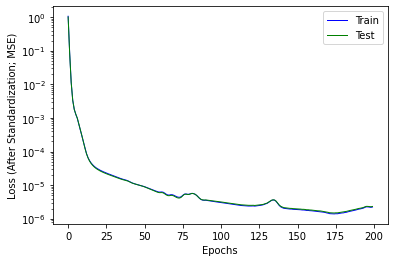

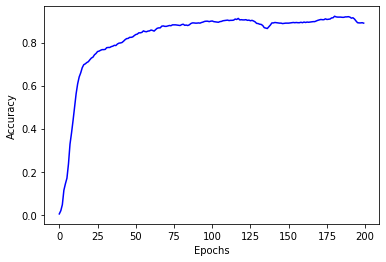

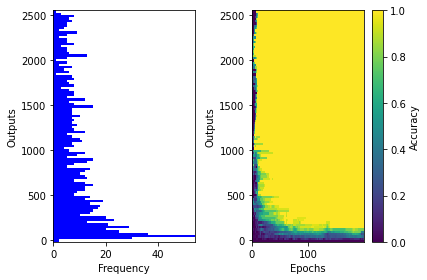

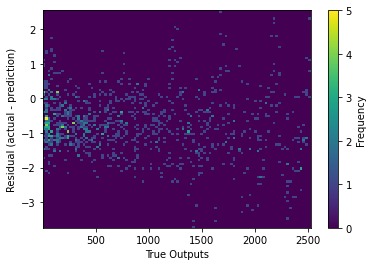

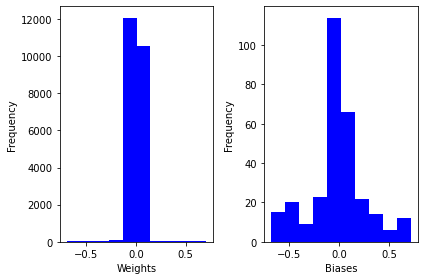

In [9]:
# Graphing
graphs = nnm.new_graphs()
nnm.graphing(graphs, graph_data, test_size, n_epochs, 100, 100)

In [10]:
graph_data['test_outputs']

tensor([[2093.1304],
        [1248.6400],
        [ 701.1165],
        [1181.9587],
        [2501.2664],
        [ 198.9357],
        [  87.4249],
        [2282.5835],
        [  31.4190],
        [1125.9570],
        [ 488.9189],
        [ 610.6022],
        [  70.5358],
        [2445.6118],
        [2148.4355],
        [ 575.3771],
        [ 191.9294],
        [1299.2531],
        [ 473.6863],
        [  87.3160],
        [  87.1260],
        [1364.2596],
        [1914.9607],
        [1999.7878],
        [ 473.1863],
        [  90.9139],
        [  30.7576],
        [1357.4563],
        [2287.6506],
        [1006.7527],
        [ 983.8508],
        [ 176.7896],
        [  64.3505],
        [  46.5196],
        [ 226.8884],
        [  38.8757],
        [ 357.1700],
        [1895.6174],
        [ 613.3784],
        [ 100.9401],
        [2363.7661],
        [ 633.3229],
        [  12.5507],
        [1159.0040],
        [1041.8522],
        [  38.1723],
        [1750.3591],
        [2035

In [24]:
# Show graphs
nnm.show_graphs(graphs)

In [25]:
# Save graphs
graphs['fig_loss'].savefig('loss.pdf')
graphs['fig_accu'].savefig('accu.pdf')
graphs['fig_accu_out'].savefig('accu_out.pdf')
graphs['fig_out_residual'].savefig('out_residual.pdf')
graphs['fig_histograms'].savefig('histograms.pdf')

In [6]:
# Analysis
param_list = [[1000, 2, 500, 1e-4, 0],[1000, 2, 500, 1e-5, 0],[1000, 2, 500, 1e-6, 0],[1000, 2, 500, 1e-7, 0],[1000, 2, 500, 1e-8, 0]] # [nodes, layers, epochs, learning rate, weight decay]
trials = 1 # The number of trials for each configuration
analysis_data = nnm.analyze(param_list, trials, inputs, outputs, test_inputs, test_outputs, batch_size)

Training done!
Training done!
Training done!
Training done!
Training done!


{'fig_analysis': <Figure size 432x288 with 1 Axes>,
 'ax_analysis': <matplotlib.axes._subplots.AxesSubplot at 0x2b638f7f4208>}

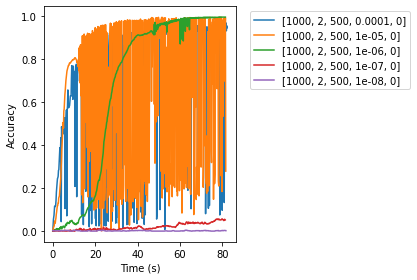

In [7]:
# Graphing
analysis_graphs = nnm.new_analysis_graphs()
nnm.analysis_graphing(analysis_graphs, analysis_data, param_list, trials)

In [8]:
analysis_graphs['fig_analysis'].savefig('analysis.pdf')

In [22]:
# Send data to be displayed
df = pd.DataFrame(data=analysis_data)

In [23]:
# Display analysis data
### Make graphs
print(df)

     nodes  layers  epochs      time  accuracy
0    100.0     1.0     0.0  0.024497     0.001
1    100.0     1.0     1.0  0.192594     0.002
2    100.0     1.0     2.0  0.347872     0.004
3    100.0     1.0     3.0  0.503090     0.008
4    100.0     1.0     4.0  0.664804     0.015
..     ...     ...     ...       ...       ...
445  100.0     1.0    45.0  7.133812     0.063
446  100.0     1.0    46.0  7.292924     0.070
447  100.0     1.0    47.0  7.449513     0.076
448  100.0     1.0    48.0  7.604756     0.079
449  100.0     1.0    49.0  7.766390     0.081

[450 rows x 5 columns]


In [17]:
# Uploads existing data and adds it to working dataset
# file_upload = read_csv("NN_Test_Data_1.csv")
# print(file_upload)
# df = df.append(file_upload)

In [24]:
# Saves run data as csv file
df.to_csv("NN_Test_Data_1.csv", index=False)